# TripAdvisor Dataset Sentiment Analysis: 
**Rationale** This dataset includes all TripAdvisor reviews written in 2015 (through part of 2016) for high review volume Vegas resorts and was collected as part of a large web crawl of over 50 Million online reviews at over 428k worldwide hotels. 

* [Dataset](https://drive.google.com/drive/folders/1nUIOHqvOoF5EkST8u_pMcL7gvKtCy0La?usp=sharing)
    * `vegas2015reviews.csv` contains the reviews 
    * `vegas_venue_info.csv` contains a list of venues in Vegas
    * Note that `gd` is the venue ID in both datasets



## Problem 1: Sentiment Analysis 

## First, let's get to know the dataset.

1. Read in the vegas reviews dataset (call this `df`)
1. Convert any columns that look like dates into Pandas datetime columns.
1. Read in the venue info dataset and merge it with the reviews dataset. (call the resulting dataframe `df`, i.e. write over the old `df`)

Answer the following for the resulting merged dataframe, `df`:
1. How many reviews are there?
1. How many unique hotels are there? Note `gd` is the ID variable for hotels on TripAdvisor.
1. What are the unique types of travel categories?
1. Plot a histogram of the review ratings. How would you describe the overall review ratings on TripAdvisor for Vegas resorts?

## Sentiment 

Use `TextBlob` library to compute the polarity and subjectivity of every review.

1. Compare the histogram of review polarity with review ratings. How are they different? What might you conclude based on this difference about how people rate and how people write?
1. To what degree are polarity and subjectivity correlated with ratings?
1. Use a groupby + corr() statement to calculate the correlation between review ratings and polarity by travel category. In which categories are review polarity most and least correlated with ratings? Any explanation for this relationship?

## Importing Libraries: 

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re
%matplotlib inline

In [2]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

## Problem 1: Sentiment Analysis

1 - Reading the Vegas Reviews dataset: 

In [3]:
df = pd.read_csv('/content/vegas2015reviews.csv')
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A


2 - Convert any columns that look like dates into Pandas datetime columns.

In [4]:
df['ratingDate'] = pd.to_datetime(df['ratingDate'])
df.ratingDate

0       2015-07-01
1       2015-07-01
2       2015-06-30
3       2015-06-13
4       2015-06-13
           ...    
46639   2015-03-15
46640   2015-03-15
46641   2015-03-15
46642   2015-03-15
46643   2015-03-14
Name: ratingDate, Length: 46644, dtype: datetime64[ns]

3 - Read in the venue info dataset and merge it with the reviews dataset. (call the resulting dataframe df, i.e. write over the old df)

In [5]:
# First csv: Vegas Reviews 2015 stored in the 'df' dataframe - 
df = pd.read_csv("/content/vegas2015reviews.csv") 
df.head()

# Second csv: Venue Information stored in 'vinfo' dataframe - 
vinfo = pd.read_csv("/content/vegas_vinfo.csv") 
vinfo.head()

# Overwriting the old 'df' dataframe - 
df = df.merge(vinfo,on=["gd"]) 
df.head()

,Unnamed: 0_x,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,ranking,rating_vol,rdetails,lnglat,rsubrating,vtype,amenities,details,v_name,rating_cat
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,"[4, 267]",9453.0,NaN,"[-115.164505, 36.12825]",{},Hotel_Review,"{'Room types': 'Suites Non-Smoking Rooms ', 'S...","{'Address:': '3121 Las Vegas Blvd. South, Las ...",Encore At Wynn Las Vegas,4.5


## Answer the following for the resulting merged dataframe, df:

1 - How many reviews are there?

In [6]:
# Length or the number of reviews: 46644
df.reviewtext

0        An excellent property! The rooms are very nice...
1        My first visit to Las Vegas and WOW!! Whilst a...
2        Some of the most beautiful hotel rooms in the ...
3        This Hotel is exceptional, its beautifully set...
4        My husband and I stayed here during a trip,to ...
                               ...                        
46639    Aria is one of the top hotels in the strip and...
46640    My husband and I just returned from Aria yeste...
46641    9 years since my last visit to Vegas & this ho...
46642    Stayed for one night for friends birthday. Gre...
46643    I stay here just because the bed and pillows a...
Name: reviewtext, Length: 46644, dtype: object

2 - How many unique hotels are there? Note gd is the ID variable for hotels on TripAdvisor.

In [7]:
# Grouping and performing count on the ID variable for hotels on TripAdvisor:
ID =  df.groupby('gd')['gd'].count()
print(ID)

gd
g45963-d1022061     830
g45963-d111709     2152
g45963-d1123368     810
g45963-d114889     2188
g45963-d114898      718
g45963-d121312     2012
g45963-d143336     2311
g45963-d1474086    1395
g45963-d1829539     881
g45963-d186114     1649
g45963-d496876      545
g45963-d503598     1152
g45963-d601419      897
g45963-d6530792     638
g45963-d675000     1301
g45963-d91673      2068
g45963-d91687      1794
g45963-d91703      1137
g45963-d91762      2905
g45963-d91770       686
g45963-d91828       665
g45963-d91840       661
g45963-d91844      3164
g45963-d91886      1233
g45963-d91891      1642
g45963-d91904      1206
g45963-d91925      1613
g45963-d91967       860
g45963-d97704      1739
g45963-d97712      1099
g45963-d97730       845
g45963-d97737      1418
g45963-d97786      1721
g45963-d97815       709
Name: gd, dtype: int64


3 - What are the unique types of travel categories?

In [8]:
# Grouping and performing count on the ID variable for hotels on TripAdvisor:
TC =  df.groupby('travel_category')['travel_category'].count()
print(TC)

travel_category
business     5905
couple      17649
family       8363
friends     10380
solo         2352
Name: travel_category, dtype: int64


4 - Plot a histogram of the review ratings. How would you describe the overall review ratings on TripAdvisor for Vegas resorts?

In [9]:
Rratings = df['reviewrating'].value_counts()

def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

In [10]:
ditribution_plot(x= Rratings.index, y= Rratings.values, name= 'Review Ratings')

Description of the overall Review Ratings on Tripadvisor for the hotels of Las Vegas:

*   There are about 2179 people who rated the hotels in Vegas '1'. These are the customers who were extremely unhappy with the choice of hotel Tripadvisor suggested them.
*   There are about 2836 people who rated the hotels in Vegas '2'. These customers found the hotels unsatisfactory.
*   There are about 6985 people who rated the hotels in Vegas '3'. These many people found the hotels somewhat satisfactory. 
*   There are about 13,761 people who rated the hotels in Vegas '4'. 
*   There are about 20,883 people who rated the hotels in Vegas '5'. These customers were extremely happy with the service provided by the hotel. 










## Sentiment: 

Use TextBlob library to compute the polarity and subjectivity of every review.

In [11]:
from textblob import TextBlob

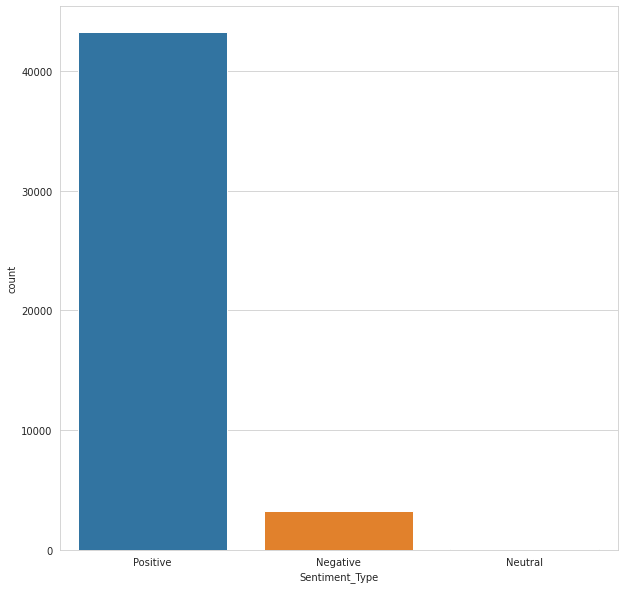

In [12]:
bloblist_desc = list()

df_usa_descr_str=df['reviewtext'].astype(str)
for row in df_usa_descr_str:
    blob = TextBlob(row)
    bloblist_desc.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    df_usa_polarity_desc = pd.DataFrame(bloblist_desc, columns = ['sentence','sentiment','polarity'])
 
def f(df_usa_polarity_desc):
    if df_usa_polarity_desc['sentiment'] > 0:
        val = "Positive"
    elif df_usa_polarity_desc['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

df_usa_polarity_desc['Sentiment_Type'] = df_usa_polarity_desc.apply(f, axis=1)

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=df_usa_polarity_desc)

1 - Compare the histogram of review polarity with review ratings. How are they different? What might you conclude based on this difference about how people rate and how people write?

After comparing both the histogram plots, which are review polarity and review ratings, there seems to be a huge difference in the way people give ratings and write their reviews. 

People tend to write reviews only when they are extremely happy or extremely unsatisfied with the service they have been provided with as they want to be vocal about their experience is what I have observed from the polarity graph.

But, when it comes to ratings, it's simple to choose on the scale between 1 to 5 according to the experience they have had. They can give the least ratings due to which the performance matrix is affected drastically. 

To conclude, the ratings graph gives a better outlook on how good the hotels actually were in my opinion. Objective ratings are better than subjective anaylsis.

2 - To what degree are polarity and subjectivity correlated with ratings?

Despite the fact that the reviews are mostly positive, the sentiment analysis reveals considerable dissent. The polarity of different aspects of a review is different. To sum up, I would say they are moderately correlated to each other.  

3 - Use a groupby + corr() statement to calculate the correlation between review ratings and polarity by travel category. In which categories are review polarity most and least correlated with ratings? Any explanation for this relationship?

In [13]:
df = df = pd.read_csv('/content/vegas2015reviews.csv')
df = pd.merge(df, df_usa_polarity_desc, left_index=True, right_index=True)
df

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,reviewtext,reviewtitle,stay_month,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,An excellent property! The rooms are very nice...,“At the top of its game”,6.0,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,My first visit to Las Vegas and WOW!! Whilst a...,“ wow!! ”,9.0,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,Some of the most beautiful hotel rooms in the ...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,"This Hotel is exceptional, its beautifully set...",“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,"My husband and I stayed here during a trip,to ...","“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46639,904218,g45963-d91925,3.0,"Washington DC, District of Columbia",1,2015-03-16,Thank you for your wonderful review. It is gre...,2015-03-15,259656436,5,Aria is one of the top hotels in the strip and...,“ Its worth it. ”,3.0,2015.0,solo,RexTanjuatco,Aria is one of the top hotels in the strip and...,0.564286,0.682143,Positive
46640,904229,g45963-d91925,NaN,"Portland, Oregon",1,2015-03-16,"Dear Bobbi, Thank you so much for choosing ARI...",2015-03-15,259650112,5,My husband and I just returned from Aria yeste...,“ Yet Another Visit ”,3.0,2015.0,couple,Bobbi S,My husband and I just returned from Aria yeste...,0.193607,0.446970,Positive
46641,904240,g45963-d91925,NaN,MANCHESTER,1,2015-03-19,Thank you for your recommendation and sharing ...,2015-03-15,259639795,5,9 years since my last visit to Vegas & this ho...,“ 40th Birthday Trip ”,3.0,2015.0,friends,ZETAMANCHESTER,9 years since my last visit to Vegas & this ho...,0.285747,0.616626,Positive
46642,904251,g45963-d91925,NaN,NaN,1,2015-03-16,"Dear Ramiro, Thank you for staying at ARIA to ...",2015-03-15,259601035,5,Stayed for one night for friends birthday. Gre...,“ BEST HOTEL IN LAS VEGAS!! ”,3.0,2015.0,friends,Ramiro G,Stayed for one night for friends birthday. Gre...,0.576713,0.772099,Positive


In [14]:
df.groupby('travel_category')[['polarity','reviewrating']].corr()

polarity  reviewrating
travel_category                                     
business        polarity      1.000000      0.261236
                reviewrating  0.261236      1.000000
couple          polarity      1.000000      0.235973
                reviewrating  0.235973      1.000000
family          polarity      1.000000      0.231084
                reviewrating  0.231084      1.000000
friends         polarity      1.000000      0.219305
                reviewrating  0.219305      1.000000
solo            polarity      1.000000      0.231777
                reviewrating  0.231777      1.000000

# 2. Preprocessing the texts 



1. Lower Casing
1. Removal of punctuations
1. Removal of stopwords
1. Removal of frequent words
1. Removal of rare words
1. Spelling checker 

LEMMATIZATION 
  

Lower Casing


In [33]:
df["text_lower"] = df["reviewtext"].str.lower()
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,reviewtitle,stay_month,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_lower
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,“At the top of its game”,6.0,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,an excellent property! the rooms are very nice...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,“ wow!! ”,9.0,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,my first visit to las vegas and wow!! whilst a...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,some of the most beautiful hotel rooms in the ...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,"this hotel is exceptional, its beautifully set..."
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,"“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,"my husband and i stayed here during a trip,to ..."


Removal of punctuations:


In [36]:
# drop the new column created in last cell
import string
#df.drop(["text_lower"], axis=1, inplace=True)

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_wo_punct"] = df["reviewtext"].apply(lambda text: remove_punctuation(text))
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,reviewtitle,stay_month,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_wo_punct
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,“At the top of its game”,6.0,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,An excellent property The rooms are very nicel...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,“ wow!! ”,9.0,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,My first visit to Las Vegas and WOW Whilst all...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,“ Mass market but luxery hotel at north end of...,6.0,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,Some of the most beautiful hotel rooms in the ...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,“ Highlight of Vegas ”,5.0,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,This Hotel is exceptional its beautifully set ...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,"“ Beautiful hotel, great location ”",6.0,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,My husband and I stayed here during a tripto V...


Removal of stopwords: 


In [37]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [43]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["text_wo_stop"] = df["text_wo_punct"].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_wo_punct,text_wo_stop,text_wo_stopfreq
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,An excellent property The rooms are very nicel...,An excellent property The rooms nicely done ge...,An excellent property nicely done generous siz...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,My first visit to Las Vegas and WOW Whilst all...,My first visit Las Vegas WOW Whilst hotels str...,My first visit Las WOW Whilst hotels strip giv...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,Some of the most beautiful hotel rooms in the ...,Some beautiful hotel rooms world Reserve Wynn ...,Some beautiful world Reserve Wynn website join...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,This Hotel is exceptional its beautifully set ...,This Hotel exceptional beautifully set everyth...,This Hotel exceptional beautifully set everyth...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,My husband and I stayed here during a tripto V...,My husband I stayed tripto Vegas friends We bo...,My husband stayed tripto friends booked Pricel...


Removal of Frequent Words:

In [44]:
from collections import Counter
cnt = Counter()
for text in df["text_wo_stop"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('I', 86258),
 ('The', 67258),
 ('room', 52116),
 ('hotel', 40620),
 ('We', 31593),
 ('great', 25690),
 ('stay', 25560),
 ('Vegas', 20682),
 ('rooms', 18412),
 ('good', 18400)]

In [45]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["text_wo_stopfreq"] = df["text_wo_stop"].apply(lambda text: remove_freqwords(text))
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_wo_punct,text_wo_stop,text_wo_stopfreq
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,An excellent property The rooms are very nicel...,An excellent property The rooms nicely done ge...,An excellent property nicely done generous siz...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,My first visit to Las Vegas and WOW Whilst all...,My first visit Las Vegas WOW Whilst hotels str...,My first visit Las WOW Whilst hotels strip giv...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,Some of the most beautiful hotel rooms in the ...,Some beautiful hotel rooms world Reserve Wynn ...,Some beautiful world Reserve Wynn website join...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,This Hotel is exceptional its beautifully set ...,This Hotel exceptional beautifully set everyth...,This Hotel exceptional beautifully set everyth...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,My husband and I stayed here during a tripto V...,My husband I stayed tripto Vegas friends We bo...,My husband stayed tripto friends booked Pricel...


Removal of Rare Words:

In [46]:
# Drop the two columns which are no more needed 
df.drop(["text_wo_punct", "text_wo_stop"], axis=1, inplace=True)

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["text_wo_stopfreqrare"] = df["text_wo_stopfreq"].apply(lambda text: remove_rarewords(text))
df.head()

,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,stay_month,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_wo_stopfreq,text_wo_stopfreqrare
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,6.0,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,An excellent property nicely done generous siz...,An excellent property nicely done generous siz...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,9.0,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,My first visit Las WOW Whilst hotels strip giv...,My first visit Las WOW Whilst hotels strip giv...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,6.0,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,Some beautiful world Reserve Wynn website join...,Some beautiful world Reserve Wynn website join...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,5.0,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,This Hotel exceptional beautifully set everyth...,This Hotel exceptional beautifully set everyth...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,6.0,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,My husband stayed tripto friends booked Pricel...,My husband stayed tripto friends booked Pricel...


Spelling Checker 

In [60]:
!pip install pyspellchecker


In [53]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
text = "speling correctin"
correct_spellings(text)

'spelling correcting'

In [66]:
text = "thnks for readin the notebook"
correct_spellings(text)

'thanks for reading the notebook'

LEMMATIZATION

In [59]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_lemmatized"] = df["text_wo_stopfreqrare"].apply(lambda text: lemmatize_words(text))
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,gd,helpful_num,location,mgrRspnDummy,mgr_res_date,mrtext,ratingDate,review_id,reviewrating,...,stay_year,travel_category,username,sentence,sentiment,polarity,Sentiment_Type,text_wo_stopfreq,text_wo_stopfreqrare,text_lemmatized
0,15044,g45963-d1123368,NaN,"Walnut Creek, California",0,NaN,NaN,2015-07-01,284818340,5,...,2015.0,business,cadby,An excellent property! The rooms are very nice...,0.515000,0.712727,Positive,An excellent property nicely done generous siz...,An excellent property nicely done generous siz...,An excellent property nicely done generous siz...
1,15045,g45963-d1123368,NaN,"Maidstone, United Kingdom",0,NaN,NaN,2015-07-01,284776986,5,...,2014.0,couple,Sonia H,My first visit to Las Vegas and WOW!! Whilst a...,0.171307,0.657576,Positive,My first visit Las WOW Whilst hotels strip giv...,My first visit Las WOW Whilst hotels strip giv...,My first visit Las WOW Whilst hotel strip give...
2,15046,g45963-d1123368,NaN,Brussels,0,NaN,NaN,2015-06-30,284187374,5,...,2015.0,couple,Globaliser,Some of the most beautiful hotel rooms in the ...,0.253931,0.515590,Positive,Some beautiful world Reserve Wynn website join...,Some beautiful world Reserve Wynn website join...,Some beautiful world Reserve Wynn website join...
3,15047,g45963-d1123368,NaN,"Colchester, United Kingdom",0,NaN,NaN,2015-06-13,279887884,5,...,2015.0,couple,Sharcoates,"This Hotel is exceptional, its beautifully set...",0.334430,0.607018,Positive,This Hotel exceptional beautifully set everyth...,This Hotel exceptional beautifully set everyth...,This Hotel exceptional beautifully set everyth...
4,15058,g45963-d1123368,NaN,"Denver, Colorado, United States",0,NaN,NaN,2015-06-13,279841140,5,...,2015.0,couple,Kimberly A,"My husband and I stayed here during a trip,to ...",0.316111,0.734931,Positive,My husband stayed tripto friends booked Pricel...,My husband stayed tripto friends booked Pricel...,My husband stayed tripto friend booked Priceli...


In [63]:
df["text_lemmatized"]

0        An excellent property nicely done generous siz...
1        My first visit Las WOW Whilst hotel strip give...
2        Some beautiful world Reserve Wynn website join...
3        This Hotel exceptional beautifully set everyth...
4        My husband stayed tripto friend booked Priceli...
                               ...                        
46639    Aria one top hotel strip unique concept So sta...
46640    My husband returned Aria yesterday took advant...
46641    9 year since last visit wasnt even built back ...
46642    Stayed one night friend birthday Great custome...
46643    bed pillow comfortable Aria starting show litt...
Name: text_lemmatized, Length: 46644, dtype: object